# Self-Driving Car Engineer Nanodegree

## Behavioral Cloning


In this notebook I will write the code for behavioral cloning: develop and train a neural network that would match the driving of a human behavior in a virtual simulator.

---
## Step 0: Load The Data

Firstly I runned the simulator locally and generated some sampling data from the simulator, and implemented code so that I can read these data.

In [53]:
# Record some sample data (2 sets of three images) for testing purposes
path_sample = './data_sample/'

In [54]:
# Current path of the data we want to process
path_data = path_sample

In [55]:
import os
import csv
import numpy as np
from PIL import Image

steering_angles = []
car_images =  []
with open(path_data + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        steering_center = float(row[3])
        # create adjusted steering measurements for the side camera images
        correction = 0.2 # hardcoded correction for the left and right camera steering
        steering_left = steering_center + correction
        steering_right = steering_center - correction
            
        steering_angles.extend([steering_center, steering_left, steering_right])
        
        # Let's read the images
        for i in range(3):
            source_path = row[i]
            filename = source_path.split('/')[-1]
            current_path = path_data + "IMG/" + filename
            car_images.append(np.asarray(Image.open(current_path)))
            #car_images.append(np.asarray(Image.open(current_path)))

In [56]:
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = path_sample + 'IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [57]:
from sklearn.model_selection import train_test_split

import os
import csv

samples = []
with open(path_data + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [58]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=1)
validation_generator = generator(validation_samples, batch_size=1)

In [59]:
# Let's pring example of what we have read
print(steering_angles)

[0.0, 0.2, -0.2, -0.3, -0.09999999999999998, -0.5, -0.5500001, -0.3500001, -0.7500001000000001]


(160, 320, 3)


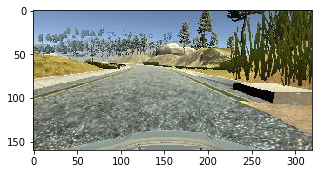

In [60]:
# Let's display a sample image captured by the simulator
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(car_images))
image = car_images[index]

print(image.shape)

plt.figure(figsize=(5,5))
plt.imshow(image, cmap="gray")

In [90]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from random import shuffle


model = Sequential()
model.add(Lambda(lambda x:x/255 - 0.5, input_shape=(160,320,3))) # this for normalization, and the '-0.5' is for mean centering the image
model.add(Cropping2D(cropping=((70,25), (0,0)))) # remove the top 70 pixels and the botton 25 pixels.
model.add(Flatten()) #model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='Adam')
history_object  = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3, verbose = 1)
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
# model.fit_generator(train_generator, steps_per_epoch= len(train_samples), validation_data=validation_generator, validation_steps=len(validation_samples), epochs=5, verbose = 1)

"""
If the above code throw exceptions, try
model.fit_generator(train_generator, steps_per_epoch= len(train_samples),
validation_data=validation_generator, validation_steps=len(validation_samples), epochs=5, verbose = 1)
"""


/home/david/miniconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/david/miniconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, steps_per_epoch=2, epochs=3, validation_steps=1)`
  


Epoch 1/3
2/2 [==============================] - 1s 256ms/step - loss: 33.5748 - val_loss: 1.7101
Epoch 2/3
2/2 [==============================] - 0s 5ms/step - loss: 4.0818 - val_loss: 3.6992
Epoch 3/3
2/2 [==============================] - 0s 7ms/step - loss: 25.8736 - val_loss: 1.1711


'\nIf the above code throw exceptions, try\nmodel.fit_generator(train_generator, steps_per_epoch= len(train_samples),\nvalidation_data=validation_generator, validation_steps=len(validation_samples), epochs=5, verbose = 1)\n'

In [89]:
# Let's try to make some predictions
name = samples[1][0].split('/')[-1]
center_image = cv2.imread(path_data + "IMG/" + name)
#center_angle = float(batch_sample[3])
images = []
images.append(center_image)
ynew = model.predict(np.array(images))
print(ynew)
#model.predict_generator(generator.pre_gen(img),steps=30)

[[1.0143268]]


dict_keys(['val_loss', 'loss'])


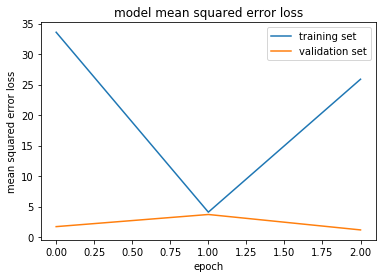

In [91]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [75]:
# Load pickled data
import pickle
import numpy as np

training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# verify that the number of images in each set matches the number of labels in the same set
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
# print out the size of each set
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [32]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [33]:
from collections import Counter

labelsClasses = Counter(y_train).keys() 
frequencyClasses = Counter(y_train).values() # counts the elements' frequency

# There are 43 classes, whose labels are as follows
print(labelsClasses)
# The frequency of the classes in the training set
print(frequencyClasses)

dict_keys([41, 31, 36, 26, 23, 1, 40, 22, 37, 16, 3, 19, 4, 11, 42, 0, 32, 27, 29, 24, 9, 5, 38, 8, 10, 35, 34, 18, 6, 13, 7, 30, 39, 21, 20, 33, 28, 12, 14, 15, 17, 2, 25])
dict_values([210, 690, 330, 540, 450, 1980, 300, 330, 180, 360, 1260, 180, 1770, 1170, 210, 180, 210, 210, 240, 240, 1320, 1650, 1860, 1260, 1800, 1080, 360, 1080, 360, 1920, 1290, 390, 270, 270, 300, 599, 480, 1890, 690, 540, 990, 2010, 1350])


The frequency of the classes in the training set does not look there is a uniform distribution. Let's do some plots to visualize it.

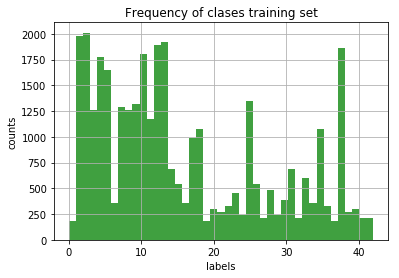

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# the histogram of the data
plt.hist(y_train, bins=n_classes, density=False, facecolor='g', alpha=0.75)


plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of clases training set')
plt.grid(True)


plt.savefig('./results/frequencyTrainingSet.png')
plt.show()

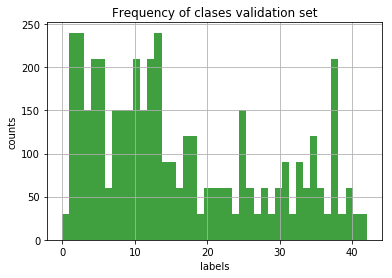

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# the histogram of the data
plt.hist(y_valid, bins=n_classes, density=False, facecolor='g', alpha=0.75)


plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of clases validation set')
plt.grid(True)
plt.savefig('./results/frequencyValidationSet.png')
plt.show()

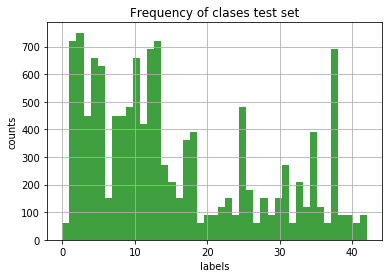

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# the histogram of the data
plt.hist(y_test, bins=n_classes, density=False, facecolor='g', alpha=0.75)


plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of clases test set')
plt.grid(True)
plt.savefig('./results/frequencyTestSet.png')
plt.show()

Seems that the distributions for the three sets (training, validation and test) have similar distribution. The problem observed in this data is that the number of samples per class does not look uniform. Some classes have more samples than others.

10


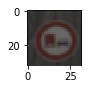

In [86]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization of an image in the training set

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

From the above data exploration, we can see there is an inbalanced number of samples for each class. It is better to have a more balanced sampling in the training data. So, I am going to generate new images (using translations, rotations, brightness change) and by doing this I will try to even a bit more the number of samples per class.

In [38]:
##### Let's build a dictionary with the number of samples needed for each class in order to meet the 3000 samples / class
from collections import Counter

# This is the minimum samples per class I will aim to target. If any class already have more than this number, no more 
# samples will be generated for this class. Classes that have less samples than this, will generated augmented
# samples of this class until reach the numSamplesPerClass. I do not put a high number here, because one of the problems
# of augmenting images might be a high correlation between images, which might be undesired for training
numSamplesPerClass = 700

currentNumSamplesPerClass = Counter(y_train)
numSamplesNeededPerClass = Counter(y_train)

print(currentNumSamplesPerClass)

numSamplesNeeded = 0

for signClass in numSamplesNeededPerClass:
    numSamplesNeededPerClass[signClass] = numSamplesPerClass - currentNumSamplesPerClass[signClass]
    if (numSamplesNeededPerClass[signClass] <0):
        numSamplesNeededPerClass[signClass] = 0
    numSamplesNeeded += numSamplesNeededPerClass[signClass]

print("Num samples needed: ")
print(numSamplesNeeded)
    

Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 35: 1080, 18: 1080, 17: 990, 31: 690, 14: 690, 33: 599, 26: 540, 15: 540, 28: 480, 23: 450, 30: 390, 16: 360, 34: 360, 6: 360, 36: 330, 22: 330, 40: 300, 20: 300, 39: 270, 21: 270, 29: 240, 24: 240, 41: 210, 42: 210, 32: 210, 27: 210, 37: 180, 19: 180, 0: 180})
Num samples needed: 
9081


In [98]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2, 
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    width_shift_range=0.3,
    height_shift_range=0.3)

# Let's augment the images. The number of samples for each class we will agument will be according to the existing 
# number of samples in the training in order to achieve a balanced number 

numAugmentedImages = 0

for iClass in range(0,43):
    numAugmentedImages += numSamplesNeededPerClass[iClass]
    
X_train_augmented = np.ndarray(shape=(numAugmentedImages,32,32,3), dtype=float)
y_train_augmented = np.ndarray(shape=(numAugmentedImages,1), dtype=int)

iTrainingSample = 0
for iClass in range(0,43):
    batches = 0
    if (numSamplesNeededPerClass[iClass] > 0):
        itemindex = np.where(y_train==iClass)
        # we select the images for the specific class specified for iClass
        for x_batch, y_batch in datagen.flow(X_train[itemindex], y_train[itemindex], batch_size=1):
            batches += 1
            for i in range(len(x_batch)):
                X_train_augmented[iTrainingSample] = x_batch[i]
                y_train_augmented[iTrainingSample] = y_batch[i]
                iTrainingSample+=1
            if batches >= numSamplesNeededPerClass[iClass]/1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
            
print(iTrainingSample)
print(numAugmentedImages)
            

9081
9081


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Helper functions

In [40]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with (pixel - 128) / 128
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    return (image_data - 128) / 128
    
def rgb2gray(rgb):
    """
    Convert to grayscale based on the formula:
    https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html
    :param rgb: The rgb image to be normalized
    :return: gray scale image
    """
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

In [41]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

from sklearn.utils import shuffle

X_train_preprocessed = np.ndarray(shape=(len(X_train)+len(X_train_augmented),32,32,1), dtype=float) # We store here the grayscale normalized images
y_train_preprocessed = np.ndarray(shape=(len(X_train)+len(X_train_augmented),1), dtype=int)

iImage = 0
indexImage = 0
for iImage in range(len(X_train)):
    image = X_train[iImage]
    gray = rgb2gray(image)
    gray_norm = normalize_grayscale(gray)
    X_train_preprocessed[indexImage] = gray_norm.reshape(32,32,1)
    y_train_preprocessed[indexImage] = y_train[iImage]
    indexImage += 1

# Let's add the augmented images
iImage = 0
for iImage in range(len(X_train_augmented)):
    image = X_train_augmented[iImage]
    gray = rgb2gray(image)
    gray_norm = normalize_grayscale(gray)
    X_train_preprocessed[indexImage] = gray_norm.reshape(32,32,1)
    y_train_preprocessed[indexImage] = y_train_augmented[iImage]
    indexImage += 1

X_train = X_train_preprocessed
y_train = y_train_preprocessed

X_valid_preprocessed = np.ndarray(shape=(len(X_valid),32,32,1), dtype=float)

iImage = 0
for iImage in range(len(X_valid)):
    image = X_valid[iImage]
    gray = rgb2gray(image)
    gray_norm = normalize_grayscale(gray)
    X_valid_preprocessed[iImage] = gray_norm.reshape(32,32,1) 

X_valid = X_valid_preprocessed
    
X_test_preprocessed = np.ndarray(shape=(len(X_test),32,32,1), dtype=float) 

iImage = 0
for iImage in range(len(X_test)):
    image = X_test[iImage]
    gray = rgb2gray(image)
    gray_norm = normalize_grayscale(gray)
    X_test_preprocessed[iImage] = gray_norm.reshape(32,32,1) 

X_test = X_test_preprocessed

# Now we have all the sets in grayscale and normalized let's proceed in shuffling the training data
# it is important to shuffle the data as otherwise this can influence how the network trains
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

#### Arquitecture solution:  LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
##### Input
The LeNet architecture accepts a 32x32 image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

##### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

##### Output
Return the result of the 2nd fully connected layer.

In [42]:
import tensorflow as tf

# start building the network by first importing the tensor flow

# The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

# After doing some testing, seems that model does not improve much after 100 epochs
EPOCHS = 100# how many times to run the training data through the network- 
# In general, the more epochs, the better the model will train, but the longer the training will take
BATCH_SIZE = 64 # how many training images to run through the network at a time
# The larger the batch size, the faster the model will train, but the processor might have a memory limit 

In [43]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    # This defines how we initialize the weights
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)) # we would use (5,5,3,6) if we were using color images 
    conv1_b = tf.Variable(tf.zeros(6))
    # We convolve the filter over the images
    # (input height - filter height + 1) / (vertical stride) = (32-5+1)/1 = 28
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Dropout regularization
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # Use a (2x2) kernel with a (2x2) stride
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Dropout regularization
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    # We flatten this output 
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Drouput regularization
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43 (43 is the number of classes in our level set)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#### Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [44]:
keep_prob = tf.placeholder(tf.float32) # probability to keep units (for the dropout regularization)

x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # placeholder that stores input patches
# We initialize to None, as then we can put a batch of any size
# We set the image dimensions to 32x32x1
y = tf.placeholder(tf.int32, (None)) # stores the labels. 
# Our lebels come throught with spare variables (integers, they are not a one-hot encoded yet)
one_hot_y = tf.one_hot(y, n_classes) # We encode the labels using the tf.one_hot function. For traffic sign classifier (y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#### Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [45]:
rate = 0.001 # how quickly update the network weights. 0.001 is a good default value

logits = LeNet(x) # we pass the input data to the LeNet function to calculate the logits
# compare the logits the ground truth labels and calculate the cross entropy
# cross entroy measures how different are the logits from the ground truth labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits) 
# average the cross entroy from the all training images
loss_operation = tf.reduce_mean(cross_entropy)
# Use the Adam optimizer to minimise the Loss function. Similar to what stochastic gradient descent does
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# we run the minimize function of the optimizer which uses backpropagation to update the network and miminize the training loss
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [46]:
# pipeline for model evaluation. Evaluate how good the model is

# compare the logit prediction to the one-hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# calculate the model overall accuracy by averaging the individual prediction accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# The above two lines is all the evaluation pipeline
saver = tf.train.Saver()

# we need to build an evaluation function, which takes a dataset as an input
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    # batches the dataset and runs it through the evaluation pipeline
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # average the accuracy of each batch to evaluate the total accuracy of the model
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [48]:
# Build a function to train an validate the model

with tf.Session() as sess:
    # we create a tensor flow session and initizlie the variables
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    # we train for the different epochs
    for i in range(EPOCHS):
        # we shuffle our training data to ensure that the training isn't bias by the order of the images
        X_train, y_train = shuffle(X_train, y_train)
        # we break the training data into batches and train the model on each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
        # at the end of each epoch we evaluate the model on our validation data    
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    # once we have trained the model, we save it
    # we can use it to load it later and modify it, or evaluate the model on test data
    # the accuracy can start high here based on the complex architecture of LeNet and that there is already good 
    # choice of the hyperparameters
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.745

EPOCH 2 ...
Validation Accuracy = 0.830

EPOCH 3 ...
Validation Accuracy = 0.869

EPOCH 4 ...
Validation Accuracy = 0.869

EPOCH 5 ...
Validation Accuracy = 0.890

EPOCH 6 ...
Validation Accuracy = 0.895

EPOCH 7 ...
Validation Accuracy = 0.893

EPOCH 8 ...
Validation Accuracy = 0.912

EPOCH 9 ...
Validation Accuracy = 0.900

EPOCH 10 ...
Validation Accuracy = 0.916

EPOCH 11 ...
Validation Accuracy = 0.910

EPOCH 12 ...
Validation Accuracy = 0.907

EPOCH 13 ...
Validation Accuracy = 0.927

EPOCH 14 ...
Validation Accuracy = 0.923

EPOCH 15 ...
Validation Accuracy = 0.922

EPOCH 16 ...
Validation Accuracy = 0.916

EPOCH 17 ...
Validation Accuracy = 0.912

EPOCH 18 ...
Validation Accuracy = 0.923

EPOCH 19 ...
Validation Accuracy = 0.932

EPOCH 20 ...
Validation Accuracy = 0.931

EPOCH 21 ...
Validation Accuracy = 0.925

EPOCH 22 ...
Validation Accuracy = 0.930

EPOCH 23 ...
Validation Accuracy = 0.933

EPOCH 24 ...
Validation Accura

#### Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [49]:
# evaluate the model on the test dataset (only do this one time), once we completly done with training
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.934


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

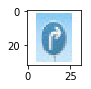

In [51]:
### Load the images and plot them here.
import matplotlib.pyplot as plt
from matplotlib.image import imread

img1 = imread('./data/newImages/img1s.jpeg')
plt.figure(figsize=(1,1))
plt.imshow(img1.squeeze(), cmap="gray")

img1 = rgb2gray(img1)
img1 = normalize_grayscale(img1)

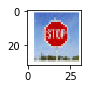

In [52]:
from matplotlib.image import imread

img2 = imread('./data/newImages/img2s.jpeg')
plt.figure(figsize=(1,1))
plt.imshow(img2.squeeze(), cmap="gray")

img2 = rgb2gray(img2)
img2 = normalize_grayscale(img2)

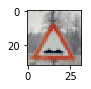

In [53]:
from matplotlib.image import imread

img3 = imread('./data/newImages/bumpyRoads.jpeg')
plt.figure(figsize=(1,1))
plt.imshow(img3.squeeze(), cmap="gray")

img3 = rgb2gray(img3)
img3 = normalize_grayscale(img3)

(32, 32, 3)


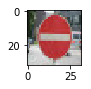

In [54]:
from matplotlib.image import imread

img4 = imread('./data/newImages/img4s.jpeg')
plt.figure(figsize=(1,1))
plt.imshow(img4.squeeze(), cmap="gray")
print(img4.shape)

img4 = rgb2gray(img4)
img4 = normalize_grayscale(img4)



(32, 32, 3)


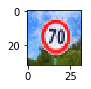

In [55]:
from matplotlib.image import imread

img5 = imread('./data/newImages/speedlimits.jpeg')
plt.figure(figsize=(1,1))
plt.imshow(img5.squeeze(), cmap="gray")
print(img5.shape)

img5 = rgb2gray(img5)
img5 = normalize_grayscale(img5)



### Predict the Sign Type for Each Image

In [99]:
# pipeline for the prediction

# get logit prediction
prediction = tf.argmax(logits, 1)

saver = tf.train.Saver()

# we need to build a prediction function, which takes as an input a set of images to make predictions
def predict(X):
    sess = tf.get_default_session()
    pred = sess.run(prediction, feed_dict={x: X, keep_prob: 1.0})
    return pred

In [100]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:    
    X = np.ndarray(shape=(5,32,32,1), dtype=float)
    X[0] = img1.reshape(32,32,1)
    X[1] = img2.reshape(32,32,1)
    X[2] = img3.reshape(32,32,1)
    X[3] = img4.reshape(32,32,1)
    X[4] = img5.reshape(32,32,1)
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = predict(X)
    print("Prediction = {}".format(pred))


INFO:tensorflow:Restoring parameters from ./lenet
Prediction = [33  2 22 17  4]


### Analyze Performance

In [58]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
expectedPrediction = [33, 14, 22, 17, 4] 
numCorrectPredictions = 0
for iPred in range(0, 5):
    if expectedPrediction[iPred] == pred[iPred]:
        numCorrectPredictions += 1
print("For the sample images on the web the model were {}% accurate".format(100*numCorrectPredictions/5.0))

For the sample images on the web the model were 80.0% accurate


The sign that was not predicted corrected was the "Stop" sign. This was the only sign that had letters. Probably the model is still not very good for signs that has letters.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [74]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
import tensorflow as tf
with tf.Session() as sess:
    X = np.ndarray(shape=(5,32,32,1), dtype=float)
    X[0] = img1.reshape(32,32,1)
    X[1] = img2.reshape(32,32,1)
    X[2] = img3.reshape(32,32,1)
    X[3] = img4.reshape(32,32,1)
    X[4] = img5.reshape(32,32,1)
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k = 5), feed_dict={x: X, keep_prob: 1.0})
    print(predictions)

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[3.87275904e-01, 3.12139243e-01, 1.02385469e-01, 4.57959771e-02,
        2.42541227e-02],
       [6.26613319e-01, 1.18249856e-01, 6.11095764e-02, 2.95233950e-02,
        2.83230413e-02],
       [9.99997258e-01, 1.58180501e-06, 5.94288906e-07, 3.24216813e-07,
        2.50023589e-07],
       [9.99488831e-01, 1.94486085e-04, 1.80814954e-04, 7.46190417e-05,
        2.66462830e-05],
       [9.91626740e-01, 7.97970872e-03, 3.93402152e-04, 7.12739663e-08,
        1.21875869e-08]], dtype=float32), indices=array([[33, 14, 40, 32, 39],
       [ 2,  5, 40, 42,  1],
       [22, 29, 20, 26, 23],
       [17, 40, 14, 16, 34],
       [ 4,  0,  1, 19, 40]], dtype=int32))


We can see that the last three images, the prediction was correct and model was quite confident. The first image was correct but the probabilitiy was very tied with anothe rimage. The second image was not predicted correctly.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")